# Lab 2: Multi-Layer Perceptrons, Backpropagation, and Evaluation

**Module:** Artificial Intelligence  
**Topic:** Neural Networks – Part 1

---

### Learning Objectives

By the end of this lab, you will be able to:

1. Implement a Multi-Layer Perceptron (MLP) with sigmoid activation from scratch
2. Train the MLP using the backpropagation algorithm
3. Apply data normalisation for neural network training
4. Classify the Iris dataset using your MLP implementation
5. Compute and interpret a confusion matrix
6. Evaluate model performance using cross-validation
7. Apply vector hashing for text classification

---

## Background

### From Perceptrons to MLPs

In Lab 1, we saw that single-layer perceptrons can only solve linearly separable problems. To solve more complex problems like XOR, we need **Multi-Layer Perceptrons (MLPs)** with hidden layers.

### The Sigmoid Activation Function

Unlike the step function, the **sigmoid function** is differentiable, which allows us to use gradient-based training:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

Its derivative (needed for backpropagation) is:

$$\sigma'(x) = \sigma(x) \cdot (1 - \sigma(x))$$

### The Backpropagation Algorithm

Backpropagation trains MLPs by:

1. **Forward pass:** Compute outputs layer by layer
2. **Compute error:** Compare output to expected value
3. **Backward pass:** Propagate error gradients back through the network
4. **Update weights:** Adjust weights to reduce error

### Data Normalisation

Neural networks work best when input features are normalised to a consistent range (e.g., [0, 1] or [-1, 1]). This prevents features with larger values from dominating the learning process.

---

## Setup

Import the necessary libraries.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

print("Libraries loaded successfully!")

Libraries loaded successfully!


---

## Exercise 1: Implement an MLP Class

Build an MLP with:

- Configurable number of input, hidden, and output neurons
- Sigmoid activation function
- Backpropagation training

In [24]:
class MLP:
    """
    Multi-Layer Perceptron with one hidden layer.
    Uses sigmoid activation and backpropagation.
    """
    
    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate=0.1):
        """
        Initialise the MLP.
        
        Parameters:
        -----
        n_inputs : int
            Number of input features
        n_hidden : int
            Number of hidden neurons
        n_outputs : int
            Number of output neurons
        learning_rate : float
            Learning rate for weight updates
        """
        self.learning_rate = learning_rate
        
        # INPUT TO HIDDEN LAYER WEIGHTS AND BIASES
        # Shape: (n_inputs, n_hidden) - each input connects to each hidden neuron
        # Random initialization in [-0.5, 0.5] breaks symmetry and provides good starting values
        self.weights_ih = np.random.uniform(-0.5, 0.5, (n_inputs, n_hidden))
        # One bias per hidden neuron
        self.bias_h = np.random.uniform(-0.5, 0.5, n_hidden)

        # HIDDEN TO OUTPUT LAYER WEIGHTS AND BIASES
        # Shape: (n_hidden, n_outputs) - each hidden neuron connects to each output neuron
        self.weights_ho = np.random.uniform(-0.5, 0.5, (n_hidden, n_outputs))
        # One bias per output neuron
        self.bias_o = np.random.uniform(-0.5, 0.5, n_outputs)
        
    def sigmoid(self, x):
        """
        Sigmoid activation function.
        Maps any input to range (0, 1), making it smooth and differentiable.
        Formula: σ(x) = 1 / (1 + e^(-x))
        """
        # Clip to avoid overflow in exp() - prevents numerical instability
        # Large positive values would cause exp(-x) to underflow to 0
        # Large negative values would cause exp(-x) to overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
        
    def sigmoid_derivative(self, x):
        """
        Derivative of sigmoid: σ'(x) = σ(x) * (1 - σ(x)).
        This elegant property makes backpropagation efficient.
        The derivative peaks at x=0 (σ'(0)=0.25) and approaches 0 for large |x|.
        """
        s = self.sigmoid(x)
        return s * (1 - s)
        
    def forward(self, X):
        """
        Forward pass through the network.
        Computes outputs layer by layer, storing intermediate values needed for backpropagation.
        
        Parameters:
        ----------
        X : array-like, shape (n_samples, n_inputs)
            Input data
        
        Returns:
        --------
        array : Output activations, shape (n_samples, n_outputs)
        """
        # Convert to numpy array if needed (handles lists, pandas DataFrames, etc.)
        X = np.array(X)
        
        # HIDDEN LAYER COMPUTATION
        # Step 1: Linear transformation - weighted sum of inputs plus bias
        # Matrix multiplication: (n_samples, n_inputs) · (n_inputs, n_hidden) = (n_samples, n_hidden)
        # Broadcasting adds bias_h to each sample
        self.z_h = np.dot(X, self.weights_ih) + self.bias_h
        
        # Step 2: Apply activation function to introduce non-linearity
        # Without activation, the network would just be a linear transformation
        self.a_h = self.sigmoid(self.z_h)  # Activations, shape: (n_samples, n_hidden)
        
        # OUTPUT LAYER COMPUTATION
        # Step 3: Linear transformation using hidden layer activations
        # (n_samples, n_hidden) · (n_hidden, n_outputs) = (n_samples, n_outputs)
        self.z_o = np.dot(self.a_h, self.weights_ho) + self.bias_o
        
        # Step 4: Apply activation to get final output predictions
        self.a_o = self.sigmoid(self.z_o)  # Output activation, shape: (n_samples, n_outputs)
        
        # Return the final predictions
        return self.a_o
        
    def backward(self, X, y):
        """
        Backward pass (backpropagation).
        Computes gradients of the loss with respect to all weights and biases,
        then updates them using gradient descent.
        
        The algorithm works backwards from output to input, using the chain rule
        to propagate error gradients through the network.
        
        Parameters:
        ----------
        X : array-like, shape (n_samples, n_inputs)
            Input data
        y : array-like, shape (n_samples, n_outputs)
            Target outputs (ground truth)
        """
        # Convert to numpy arrays for consistent handling
        X = np.array(X)
        y = np.array(y)
        
        # Number of samples - used to average gradients across the batch
        m = X.shape[0]
        
        # STEP 1: COMPUTE OUTPUT LAYER ERROR
        # Error signal δ_o = (predicted - actual) * derivative of activation
        # This represents how much each output neuron contributed to the error
        # Shape: (n_samples, n_outputs)
        # The derivative term scales the error based on the slope of the sigmoid
        error_output = (self.a_o - y) * self.sigmoid_derivative(self.z_o)
        
        # STEP 2: BACKPROPAGATE ERROR TO HIDDEN LAYER
        # Project output errors back through weights, then multiply by hidden activation derivative
        # (n_samples, n_outputs) · (n_outputs, n_hidden) = (n_samples, n_hidden)
        # .T transposes weights_ho to align dimensions correctly
        # This tells us how much each hidden neuron contributed to the output error
        error_hidden = np.dot(error_output, self.weights_ho.T) * self.sigmoid_derivative(self.z_h)
        
        # STEP 3: COMPUTE GRADIENTS FOR OUTPUT LAYER
        # Gradient of weights: derivative of loss w.r.t. weights
        # Formula: ∂L/∂W = (activations)^T · (errors) / batch_size
        # (n_hidden, n_samples) · (n_samples, n_outputs) = (n_hidden, n_outputs)
        # We average over the batch (/m) for stable gradient estimates
        grad_weights_ho = np.dot(self.a_h.T, error_output) / m
        
        # Gradient of biases: average error across all samples
        # Biases affect all samples equally, so we just average the errors
        grad_bias_o = np.mean(error_output, axis=0)  # Shape: (n_outputs,)
        
        # STEP 4: COMPUTE GRADIENTS FOR HIDDEN LAYER
        # Same process as output layer, but using input X instead of hidden activations
        # (n_inputs, n_samples) · (n_samples, n_hidden) = (n_inputs, n_hidden)
        grad_weights_ih = np.dot(X.T, error_hidden) / m
        
        # Average hidden layer errors for bias gradient
        grad_bias_h = np.mean(error_hidden, axis=0)  # Shape: (n_hidden,)
        
        # STEP 5: UPDATE WEIGHTS AND BIASES USING GRADIENT DESCENT
        # Formula: θ_new = θ_old - learning_rate * gradient
        # We move weights in the opposite direction of the gradient to minimize loss
        # The learning rate controls the step size
        
        # Update output layer parameters
        self.weights_ho -= self.learning_rate * grad_weights_ho
        self.bias_o -= self.learning_rate * grad_bias_o
        
        # Update hidden layer parameters
        self.weights_ih -= self.learning_rate * grad_weights_ih
        self.bias_h -= self.learning_rate * grad_bias_h
        
    def train(self, X, y, epochs, verbose=True):
        """
        Train the network.
        
        Parameters:
        ----------
        X : array-like, shape (n_samples, n_inputs)
            Training inputs
        y : array-like, shape (n_samples, n_outputs)
            Training targets
        epochs : int
            Number of training epochs
        verbose : bool
            Print progress if True
        
        Returns:
        --------
        list : Training loss history
        """
        losses = []
        
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)
            
            # Compute loss (Mean Squared Error)
            loss = np.mean((y - output) ** 2)
            losses.append(loss)
            
            # Backward pass
            self.backward(X, y)
            
            if verbose and (epoch % 100 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch}: Loss = {loss:.6f}")
        
        return losses
    
    def predict(self, X):
        """
        Make predictions.
        
        Returns the class with highest output activation.
        """
        output = self.forward(X)
        return np.argmax(output, axis=1)

print("MLP class defined successfully!")

MLP class defined successfully!


---

## Exercise 2: Test the MLP on XOR

Before using the MLP on real data, verify it works on XOR (from Lab 1).

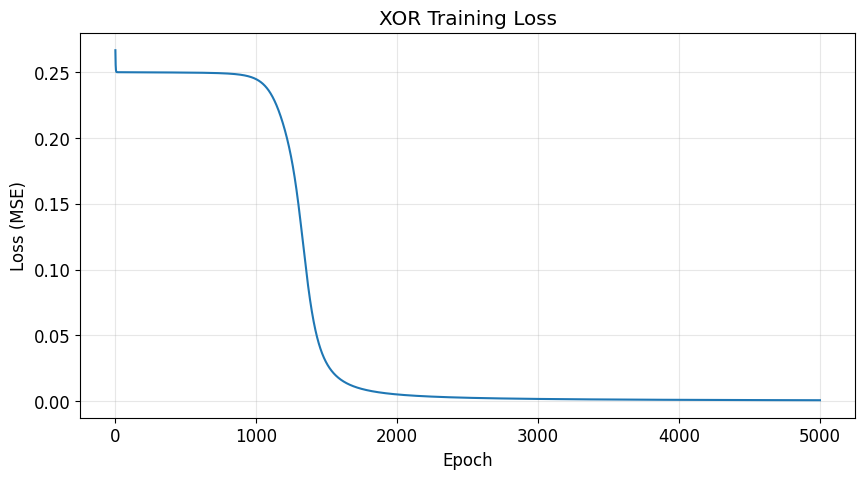


XOR Predictions:
--------------------------------------------------
Input: [0 0] -> Output: 0.0251 -> Rounded: 0 (Expected: 0) ✓
Input: [0 1] -> Output: 0.9708 -> Rounded: 1 (Expected: 1) ✓
Input: [1 0] -> Output: 0.9770 -> Rounded: 1 (Expected: 1) ✓
Input: [1 1] -> Output: 0.0241 -> Rounded: 0 (Expected: 0) ✓


In [25]:
# Define XOR data
# XOR truth table: 0 XOR 0 = 0, 0 XOR 1 = 1, 1 XOR 0 = 1, 1 XOR 1 = 0
# This is a classic non-linearly separable problem that requires a hidden layer to solve

# Input data: All possible combinations of two binary inputs
X_xor = np.array([
    [0, 0],  # First input: both bits are 0
    [0, 1],  # Second input: first bit 0, second bit 1
    [1, 0],  # Third input: first bit 1, second bit 0
    [1, 1]   # Fourth input: both bits are 1
])

# Target outputs: Expected XOR results for each input pair
# Reshaped to (4, 1) to match MLP output layer format (n_samples, n_outputs)
y_xor = np.array([[0],   # 0 XOR 0 = 0
                  [1],   # 0 XOR 1 = 1
                  [1],   # 1 XOR 0 = 1
                  [0]])  # 1 XOR 1 = 0

# Create and train MLP
np.random.seed(42)
mlp_xor = MLP(n_inputs=2, n_hidden=4, n_outputs=1, learning_rate=2.0)
losses_xor = mlp_xor.train(X_xor, y_xor, epochs=5000, verbose=False)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses_xor)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('XOR Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

# Test predictions
print("\nXOR Predictions:")
print("-" * 50)

for i in range(len(X_xor)):
    output = mlp_xor.forward(X_xor[i:i+1])
    rounded = round(output[0][0])
    correct = "✓" if rounded == y_xor[i][0] else "✗"
    print(f"Input: {X_xor[i]} -> Output: {output[0][0]:.4f} -> Rounded: {rounded} (Expected: {y_xor[i][0]}) {correct}")


---

## Exercise 3: Load and Prepare the Iris Dataset

The Iris dataset contains 150 samples of iris flowers with:

- 4 features: sepal length, sepal width, petal length, petal width
- 3 classes: Setosa, Versicolor, Virginica

### Task 3.1: Load and Explore the Data

In [26]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

print("Iris Dataset Overview")
print("=" * 50)
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names: {iris.feature_names}")
print(f"Target names: {iris.target_names}")
print(f"\nClass distribution: {np.bincount(y)}")

Iris Dataset Overview
Features shape: (150, 4)
Target shape: (150,)

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']

Class distribution: [50 50 50]


### Task 3.2: Normalise the Data

Normalise features to [0, 1] range for better neural network performance.

In [27]:
# Normalise features to [0, 1]
scaler = MinMaxScaler()
X_normalised = scaler.fit_transform(X)

print("Data Normalisation")
print("=" * 50)
print("Before normalisation:")
print(f"  Min: {X.min(axis=0)}")
print(f"  Max: {X.max(axis=0)}")
print("\nAfter normalisation:")
print(f"  Min: {X_normalised.min(axis=0)}")
print(f"  Max: {X_normalised.max(axis=0)}")

Data Normalisation
Before normalisation:
  Min: [4.3 2.  1.  0.1]
  Max: [7.9 4.4 6.9 2.5]

After normalisation:
  Min: [0. 0. 0. 0.]
  Max: [1. 1. 1. 1.]


### Task 3.3: One-Hot Encode the Targets

For multi-class classification with neural networks, we convert class labels to one-hot encoding:

- Class 0 → [1, 0, 0]
- Class 1 → [0, 1, 0]
- Class 2 → [0, 0, 1]

In [28]:
# One-hot encode targets
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

print("One-Hot Encoding")
print("=" * 50)
print(f"Original y[:5]: {y[:5]}")
print(f"\nOne-hot y[:5]:")
print(y_onehot[:5])
print(f"\nEncoding: 0 → [1,0,0], 1 → [0,1,0], 2 → [0,0,1]")

One-Hot Encoding
Original y[:5]: [0 0 0 0 0]

One-hot y[:5]:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]

Encoding: 0 → [1,0,0], 1 → [0,1,0], 2 → [0,0,1]


### Task 3.4: Split into Training and Test Sets

In [29]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_normalised, y_onehot, test_size=0.2, random_state=42, stratify=y
)

# Get original labels for evaluation (convert from one-hot back to class indices)
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("Train/Test Split")
print("=" * 50)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train/Test Split
Training set: 120 samples
Test set: 30 samples


---

## Exercise 4: Train and Evaluate the MLP on Iris

### Task 4.1: Create and Train the Network

**Suggested architecture:**

- 4 input neurons (one per feature)
- 8 hidden neurons
- 3 output neurons (one per class)

In [30]:
# STEP 1: SET RANDOM SEED FOR REPRODUCIBILITY
# This ensures that the random weight initialization produces the same results every time
# Important for debugging and comparing results across different runs
np.random.seed(42)

# STEP 2: CREATE THE NEURAL NETWORK ARCHITECTURE
# Network structure for Iris classification:
# - Input layer: 4 neurons (one for each feature: sepal length, sepal width, petal length, petal width)
# - Hidden layer: 8 neurons (sufficient capacity to learn non-linear patterns in Iris data)
# - Output layer: 3 neurons (one for each class: Setosa, Versicolor, Virginica)
# - Learning rate: 0.5 (controls step size during gradient descent; higher = faster but less stable)
#
# Why 8 hidden neurons?
# - Rule of thumb: between input size and output size, often 2x input size
# - Enough capacity to learn complex decision boundaries without overfitting
# - Too few neurons = underfitting (can't learn patterns)
# - Too many neurons = overfitting (memorizes training data, poor generalization)
mlp_iris = MLP(n_inputs=4, n_hidden=8, n_outputs=3, learning_rate=0.5)

print("Training MLP on Iris dataset...")
print("=" * 50)

# STEP 3: TRAIN THE NETWORK USING BACKPROPAGATION
# Training process:
# - Epochs: 1000 iterations through the entire training dataset
# - Each epoch:
#   1. Forward pass: Compute predictions for all training samples
#   2. Calculate loss: Measure error between predictions and actual labels (MSE)
#   3. Backward pass: Compute gradients using backpropagation
#   4. Update weights: Adjust weights to reduce loss (gradient descent)
# - Verbose: Print loss every 100 epochs to monitor learning progress
# - Returns: List of loss values for each epoch (used for visualization)
#
# What's happening during training:
# - Network learns to recognize patterns in the 4D feature space
# - Hidden layer learns intermediate representations (feature combinations)
# - Output layer learns to map hidden features to class probabilities
# - Loss should decrease over time as the network improves
losses_iris = mlp_iris.train(X_train, y_train, epochs=1000, verbose=True)

Training MLP on Iris dataset...
Epoch 0: Loss = 0.245520
Epoch 100: Loss = 0.212343
Epoch 200: Loss = 0.192939
Epoch 300: Loss = 0.160408
Epoch 400: Loss = 0.134717
Epoch 500: Loss = 0.121064
Epoch 600: Loss = 0.113445
Epoch 700: Loss = 0.108393
Epoch 800: Loss = 0.104507
Epoch 900: Loss = 0.101203
Epoch 999: Loss = 0.098243


### Task 4.2: Plot Training Loss

Visualise how the loss decreases during training.

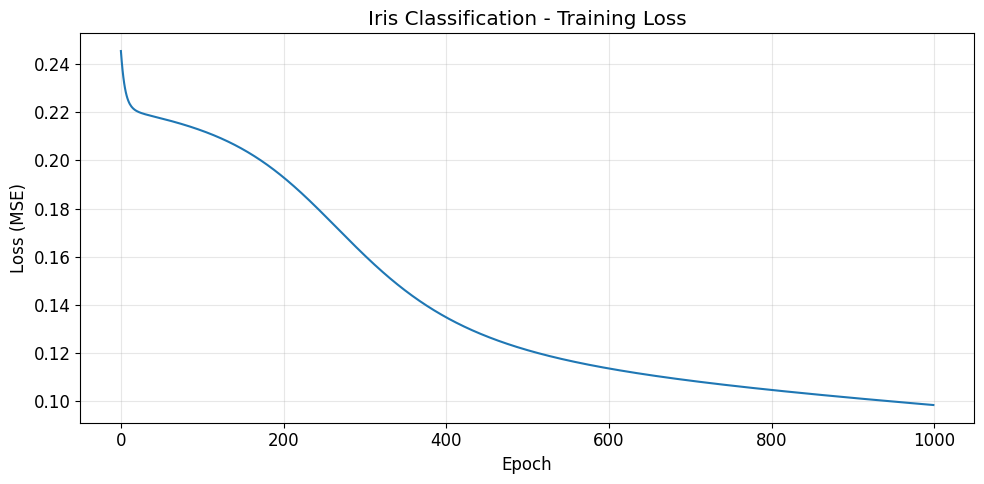

Figure saved as 'iris_training_loss.png'


In [31]:
# VISUALIZE TRAINING PROGRESS
# The loss curve reveals how well the network is learning:

# Create figure with specified size
plt.figure(figsize=(10, 5))

# Plot loss values across all epochs
# X-axis: epoch number (0 to 999)
# Y-axis: Mean Squared Error (MSE) loss value
# Expected pattern: Loss should decrease rapidly at first, then plateau
plt.plot(losses_iris)

# Add axis labels for clarity
plt.xlabel('Epoch')  # Training iteration number
plt.ylabel('Loss (MSE)')  # Mean Squared Error between predictions and targets

# Add descriptive title
plt.title('Iris Classification - Training Loss')

# Add grid for easier reading of values
plt.grid(True, alpha=0.3)  # Semi-transparent grid lines

# Optimize layout to prevent label cutoff
plt.tight_layout()

# Save figure to disk for reports/documentation
plt.savefig('iris_training_loss.png', dpi=150)  # High resolution (150 dots per inch)

# Display the plot
plt.show()

print("Figure saved as 'iris_training_loss.png'")

# INTERPRETING THE LOSS CURVE:
# - Steep decline early: Network rapidly learns major patterns
# - Gradual decline later: Fine-tuning of weights for better accuracy
# - Plateau: Network has converged (further training won't help much)
# - Fluctuations: Normal due to batch-based updates and stochastic nature
# - Increasing loss: Would indicate overfitting or too high learning rate (not expected here)

### Task 4.3: Evaluate on Test Set

In [32]:
# EVALUATE THE TRAINED NETWORK ON UNSEEN TEST DATA
# This measures how well the network generalizes to new data it hasn't seen during training

# STEP 1: MAKE PREDICTIONS ON TEST SET
# Process:
# 1. Forward pass through network with test inputs
# 2. Get output activations for each of 3 classes (shape: [n_samples, 3])
# 3. Choose class with highest activation (argmax)
# Result: Array of predicted class labels (0, 1, or 2)
y_pred = mlp_iris.predict(X_test)

# STEP 2: CONVERT ONE-HOT ENCODED TARGETS TO CLASS LABELS
# y_test is currently one-hot encoded: [[1,0,0], [0,1,0], [0,0,1], ...]
# We need class labels for comparison: [0, 1, 2, ...]
# argmax finds the index of the largest value (the "1" in each row)
# Example: [0, 1, 0] -> argmax gives 1 (middle position)
y_true = np.argmax(y_test, axis=1)

# STEP 3: CALCULATE ACCURACY
# Accuracy = (Number of correct predictions) / (Total predictions)
# This is the most basic performance metric for classification
# For Iris, random guessing would give ~33.33% accuracy (3 classes)
# A good model should achieve 90%+ accuracy
accuracy = np.mean(y_pred == y_true)  # y_pred == y_true creates boolean array, mean converts to fraction

# STEP 4: DISPLAY RESULTS
print("Test Set Evaluation")
print("=" * 50)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Correct predictions: {np.sum(y_pred == y_true)}/{len(y_true)}")

# UNDERSTANDING THE RESULTS:
# - High accuracy (>90%): Network learned good decision boundaries
# - Low accuracy (<70%): May need more training, better architecture, or feature engineering
# - Test accuracy lower than training accuracy: Normal, indicates some overfitting
# - Test accuracy higher than training: Unusual, might indicate data leakage or lucky split

Test Set Evaluation
Test Accuracy: 80.00%
Correct predictions: 24/30


---

## Exercise 5: Confusion Matrix (From Scratch)

A **confusion matrix** is a table that shows the performance of a classification model by comparing actual vs predicted labels.

**For binary classification:**

|            | Predicted + | Predicted - |
|------------|-------------|-------------|
| Actual +   | TP          | FN          |
| Actual -   | FP          | TN          |

- Off-diagonal elements = misclassifications

- **TP (True Positive):** Correctly predicted positive- Diagonal elements = correct predictions

- **TN (True Negative):** Correctly predicted negative  - Columns represent predicted classes

- **FP (False Positive):** Incorrectly predicted positive (Type I error)- Rows represent actual classes

- **FN (False Negative):** Incorrectly predicted negative (Type II error)**For multi-class classification (like Iris):**


### Task 5.1: Implement Confusion Matrix

In [33]:
def compute_confusion_matrix(y_true, y_pred, n_classes):
    """
    Compute confusion matrix from scratch.
    
    The confusion matrix is a (n_classes x n_classes) table where:
    - cm[i, j] = number of samples with true label i predicted as label j
    - cm[i, i] = correct predictions for class i (diagonal)
    - cm[i, j] where i≠j = misclassifications
    
    Parameters
    ----------
    y_true : array-like
        True class labels (e.g., [0, 1, 2, 1, 0, ...])
    y_pred : array-like
        Predicted class labels (e.g., [0, 1, 2, 2, 0, ...])
    n_classes : int
        Number of classes (3 for Iris: Setosa, Versicolor, Virginica)
    
    Returns
    -------
    ndarray
        Confusion matrix of shape (n_classes, n_classes)
    """
    # Initialize confusion matrix with zeros
    # dtype=int because we're counting samples (whole numbers only)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    # Populate the confusion matrix
    # Loop through each true label and predicted label pair
    for true, pred in zip(y_true, y_pred):
        # Increment the count at position [true_label, predicted_label]
        # Example: If actual=0 and predicted=0, increment cm[0, 0] (correct prediction)
        # Example: If actual=1 and predicted=2, increment cm[1, 2] (misclassification)
        cm[true, pred] += 1
    
    # Example confusion matrix for 3 classes:
    #              Predicted
    #              0   1   2
    # Actual  0  [10   0   0]  <- All Setosa correctly classified
    #         1  [ 0   9   1]  <- 9 Versicolor correct, 1 misclassified as Virginica
    #         2  [ 0   1   9]  <- 9 Virginica correct, 1 misclassified as Versicolor
    #
    # Diagonal elements = correct predictions
    # Off-diagonal elements = misclassifications
    
    return cm


# Apply the function to our Iris predictions
# y_true: actual labels from test set (converted from one-hot in Task 4.3)
# y_pred: predictions from our trained MLP
# n_classes=3: Iris has 3 species
cm = compute_confusion_matrix(y_true, y_pred, n_classes=3)

# Display the confusion matrix
print("Confusion Matrix (from scratch)")
print("=" * 50)
print(cm)
print("\nRows = Actual, Columns = Predicted")
print("Diagonal = Correct predictions")

Confusion Matrix (from scratch)
[[10  0  0]
 [ 0  4  6]
 [ 0  0 10]]

Rows = Actual, Columns = Predicted
Diagonal = Correct predictions


### Task 5.2: Verify with sklearn

Compare your from-scratch implementation with sklearn's built-in function.

In [35]:
# Import sklearn's confusion matrix function
# Import under an alias to distinguish from our implementation
from sklearn.metrics import confusion_matrix as sklearn_cm, classification_report

# Compute confusion matrix using sklearn
# sklearn's built-in function uses optimized code but follows the same logic
# This serves as a sanity check for our from-scratch implementation
cm_sklearn = sklearn_cm(y_true, y_pred)

# Compare our implementation with sklearn's
print("Verification with sklearn")
print("=" * 50)
print("Our confusion matrix:")
print(cm)
print("\nsklearn confusion matrix:")
print(cm_sklearn)
print(f"\nMatrices match: {np.array_equal(cm, cm_sklearn)}")

# Display detailed classification report
# sklearn's classification_report computes precision, recall, f1-score for each class
# - Precision: Of all samples predicted as class X, how many were actually class X?
# - Recall: Of all actual class X samples, how many did we correctly predict?
# - F1-score: Harmonic mean of precision and recall (balanced metric)
# - Support: Number of actual samples of each class in the test set
print("\n\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=iris.target_names))

Verification with sklearn
Our confusion matrix:
[[10  0  0]
 [ 0  4  6]
 [ 0  0 10]]

sklearn confusion matrix:
[[10  0  0]
 [ 0  4  6]
 [ 0  0 10]]

Matrices match: True


Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.40      0.57        10
   virginica       0.62      1.00      0.77        10

    accuracy                           0.80        30
   macro avg       0.88      0.80      0.78        30
weighted avg       0.88      0.80      0.78        30



### Task 5.3: Visualise the Confusion Matrix

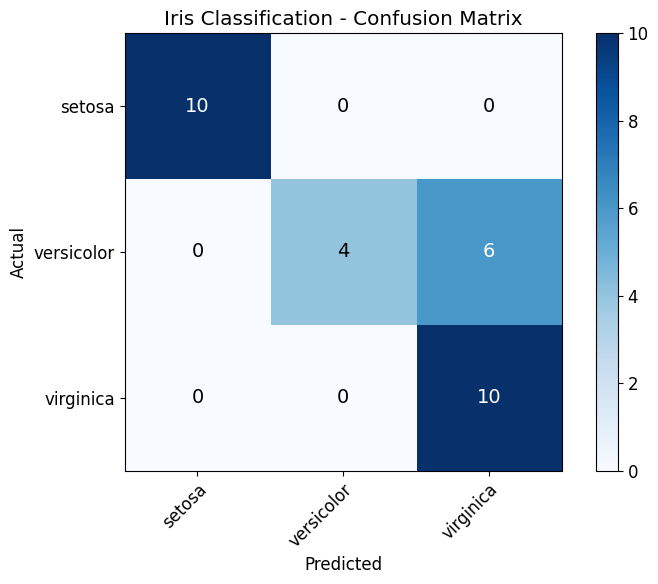

Figure saved as 'iris_confusion_matrix.png'


In [40]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """
    Plot confusion matrix as a color-coded heatmap for easy interpretation.
    
    Parameters
    ----------
    cm : array-like
        Confusion matrix to visualize
    class_names : list
        Names of classes for axis labels
    title : str
        Title for the plot
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Display confusion matrix as heatmap
    # imshow creates a color-coded image where darker blue = higher values
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Configure axis labels and ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add numeric values to each cell
    # Calculate threshold: values > half of max are considered "dark"
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Add text annotation showing the count in each cell
            # Choose text color based on cell darkness for contrast
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center",
                   va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=14)
    
    # Optimize layout and save figure
    plt.tight_layout()
    plt.savefig('iris_confusion_matrix.png', dpi=150)
    plt.show()
    
    print("Figure saved as 'iris_confusion_matrix.png'")
    
    return fig


# Create and display the visualization
fig = plot_confusion_matrix(cm, iris.target_names, "Iris Classification - Confusion Matrix")

### Task 5.4: Compute Performance Metrics

From the confusion matrix, compute:

- **Accuracy** = (TP + TN) / Total
- **Precision** (per class) = TP / (TP + FP)
- **Recall / Sensitivity** (per class) = TP / (TP + FN)

In [41]:
def compute_metrics(cm):
    """
    Compute accuracy, precision, and recall from confusion matrix.
    
    These metrics provide different perspectives on model performance:
    - Accuracy: Overall correctness
    - Precision: Quality of positive predictions (how many predicted X are actually X?)
    - Recall: Coverage of actual positives (how many actual X did we find?)
    
    Parameters
    ----------
    cm : ndarray
        Confusion matrix of shape (n_classes, n_classes)
        
    Returns
    -------
    accuracy : float
        Overall accuracy
    precision : ndarray
        Precision for each class
    recall : ndarray
        Recall for each class
    """
    # Get number of classes from confusion matrix shape
    n_classes = cm.shape[0]
    
    # Compute overall accuracy
    # Accuracy = (Total Correct Predictions) / (Total Predictions)
    # np.trace(cm) sums the diagonal (correct predictions)
    accuracy = np.trace(cm) / np.sum(cm)
    
    # Initialize arrays to store per-class metrics
    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    
    # Calculate precision and recall for each class
    for i in range(n_classes):
        # True Positives (TP): Correctly predicted as class i
        tp = cm[i, i]
        
        # False Positives (FP): Incorrectly predicted as class i
        # Sum of column i minus the TP
        fp = np.sum(cm[:, i]) - tp
        
        # False Negatives (FN): Should be class i but predicted as something else
        # Sum of row i minus the TP
        fn = np.sum(cm[i, :]) - tp
        
        # Precision: Of all samples predicted as class i, how many were correct?
        # Formula: TP / (TP + FP)
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        # Recall: Of all actual class i samples, how many did we find?
        # Formula: TP / (TP + FN)
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return accuracy, precision, recall


# Apply the function to our confusion matrix
accuracy, precision, recall = compute_metrics(cm)

# Display the metrics in a formatted table
print("Performance Metrics")
print("=" * 50)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print("\nPer-class metrics:")
print(f"{'Class':<15} {'Precision':<15} {'Recall':<15}")
print("-" * 45)
for i, name in enumerate(iris.target_names):
    print(f"{name:<15} {precision[i]*100:>8.2f}% {recall[i]*100:>12.2f}%")

Performance Metrics
Overall Accuracy: 80.00%

Per-class metrics:
Class           Precision       Recall         
---------------------------------------------
setosa            100.00%       100.00%
versicolor        100.00%        40.00%
virginica          62.50%       100.00%


---

## Exercise 6: Compare with sklearn's MLPClassifier

Verify your implementation by comparing with sklearn's built-in MLP.

**Note:** sklearn's MLPClassifier typically achieves higher accuracy because it includes:

- Better weight initialisation (Xavier/Glorot)
- Momentum to smooth gradient updates
- Adaptive learning rate
- L2 regularisation
- Softmax output with cross-entropy loss (optimal for classification)

Our simpler implementation demonstrates the core concepts but lacks these optimisations.

sklearn also handles one-hot encoding internally when you pass class labels.

In [42]:
# sklearn MLP
sklearn_mlp = MLPClassifier(
    hidden_layer_sizes=(8,),        # One hidden layer with 8 neurons
    activation='logistic',           # Sigmoid activation
    solver='sgd',                    # Stochastic gradient descent
    learning_rate_init=0.5,
    max_iter=1000,
    random_state=42
)

# Train (sklearn receives class labels, not one-hot)
sklearn_mlp.fit(X_train, y_train_labels)

# Evaluate
sklearn_pred = sklearn_mlp.predict(X_test)
sklearn_accuracy = accuracy_score(y_test_labels, sklearn_pred)

print("Comparison: Our MLP vs sklearn MLPClassifier")
print("=" * 50)
print(f"Our MLP Accuracy:     {accuracy * 100:.2f}%")
print(f"sklearn MLP Accuracy: {sklearn_accuracy * 100:.2f}%")
print("\nsklearn typically achieves higher accuracy due to its optimisations.")

Comparison: Our MLP vs sklearn MLPClassifier
Our MLP Accuracy:     80.00%
sklearn MLP Accuracy: 96.67%

sklearn typically achieves higher accuracy due to its optimisations.


---

## Exercise 7: Cross-Validation

Use 10-fold cross-validation to get a more robust estimate of model performance.

In [43]:
# Create sklearn MLP for cross-validation
# TODO: add code here to create an sklearn MLP
## Hint: see Exercise 6

# 10-fold cross-validation
cv_scores = cross_val_score(sklearn_mlp_cv, X_normalised, y, cv=10)

print("10-Fold Cross-Validation Results")
print("=" * 50)
print(f"Fold scores: {cv_scores}")
print(f"\nMean accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard deviation: {cv_scores.std() * 100:.2f}%")
print(f"95% confidence interval: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100*1.96:.2f}%")

# Visualise
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), cv_scores * 100)
plt.axhline(y=cv_scores.mean() * 100, color='r', linestyle='--', label=f'Mean: {cv_scores.mean()*100:.2f}%')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('10-Fold Cross-Validation Results')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.savefig('cross_validation_results.png', dpi=150)
plt.show()

NameError: name 'sklearn_mlp_cv' is not defined